### PaviaU_Data -> pavia_data.ipynb

In [2]:
# from scipy.io import loadmat
# paviaU = loadmat(r'D:\HSI Project\Updated_Work\HSI_Classification\HybridSN\PaviaU.mat')['paviaU']
# paviaU_gt = loadmat(r'D:\HSI Project\Updated_Work\HSI_Classification\HybridSN\PaviaU_gt.mat')['paviaU_gt']
# print(paviaU.shape,paviaU_gt.shape)

In [5]:
import numpy as np
import torch
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [1]:
import shutil
shutil.rmtree("D:\\HSI Project\\Updated_Work\\HSI_Classification\\Minerals_Dataset\\Patches_Data\\")

In [20]:
from scipy.io import loadmat
hsi = np.transpose(loadmat(r'D:\HSI Project\Updated_Work\HSI_Classification\Minerals_Dataset\Minerals_mat_files\0000_A.mat')['HDR'][:],axes=(1,2,0))
mask = loadmat(r'D:\HSI Project\Updated_Work\HSI_Classification\Minerals_Dataset\Minerals_mat_files\0000_A_gt.mat')['MASK'][:]
X,Y = createImageCubes(hsi,mask,7,False)

In [22]:
for id in range(131200):
    np.save(arr=X[id].astype(np.float16),file=f"D:\\HSI Project\\Updated_Work\\HSI_Classification\\Minerals_Dataset\\Patches_Data\\0000_{id}.npy")

In [3]:
import numpy as np
np.max(paviaU),np.min(paviaU)

(8000, 0)

### Showing Hyperspectral Data Cube and Ground Truth

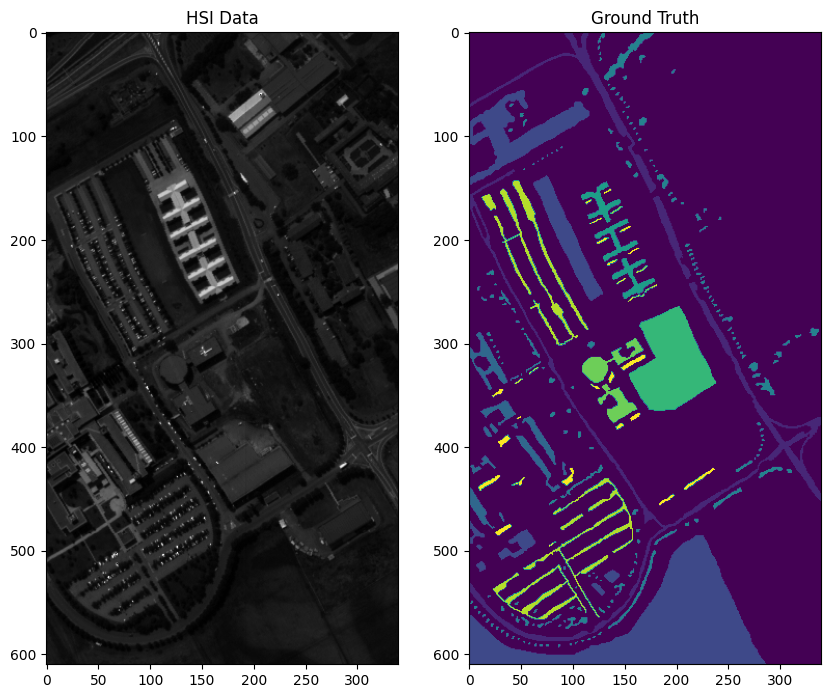

In [4]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(paviaU[:,:,20],cmap='gray') # 20 is just a random number
ax[0].set_title('HSI Data')
ax[1].imshow(paviaU_gt)
ax[1].set_title('Ground Truth')
plt.show()

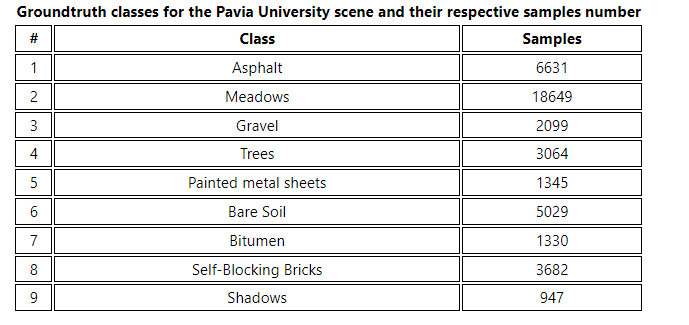

### Utils

In [5]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [7]:
paviaU_PCA,pca = applyPCA(paviaU,numComponents=15)

### Building Dataset - n x n neighbourhood kernel

In [8]:
paviaU_patches, paviaU_patchLabels = createImageCubes(paviaU_PCA, paviaU_gt, windowSize=25)

In [10]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(paviaU_patches, paviaU_patchLabels, 0.90)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((4277, 25, 25, 15), (38499, 25, 25, 15), (4277,), (38499,))

In [11]:
import torch
ytrain_onehot = torch.nn.functional.one_hot(torch.tensor(ytrain).long(), num_classes=9)
ytest_onehot = torch.nn.functional.one_hot(torch.tensor(ytest).long(), num_classes=9)

In [9]:
# import torch.nn.functional as F
# import torch
# k = 5
# pU = torch.tensor(np.array(paviaU.copy(),dtype=np.float64))
# # print(pU.shape)
# pU = pU.unsqueeze(0).permute(0,3,1,2)
# # print(pU.shape)
# padding = [k//2,k//2,k//2,k//2]
# padd = F.pad(pU,padding).numpy()
# # print(padd.shape)
# paviU_data = {}
# # dataset_intensity_summ = np.zeros((pU.shape[1]))
# # count_pixels = np.zeros((pU.shape[1]))
# for i in range(1,10):
#     paviU_data[f"label_{i}"] = []
# for i in range(pU.shape[2]):
#     for j in range(pU.shape[3]):
#         temp = padd[:,:,i:i+k//2+k//2+1,j:j+k//2+k//2+1]
#         # dataset_intensity_summ += np.sum(temp,axis=(2,3)).flatten()
#         # count_pixels += np.ones(pU.shape[1])*(k*k)
#         label = paviaU_gt[i,j]
#         if label!=0:
#             paviU_data[f"label_{label}"].append(temp)

In [10]:
# x = np.random.randint(low=0, high=5, size=(1,2,5,5))
# print(x)
# print(np.sum(x,axis=(2,3)).flatten())

# print((dataset_intensity_summ/count_pixels)[:10])

In [11]:
# for key in paviU_data:
#     print(key," ",len(paviU_data[key])," ",type(paviU_data[key][0]))

In [12]:
# paviU_data[key][0]

### Creating Training and Testing Data

In [13]:
# from tqdm import tqdm
# import random
# paviaU_train_test_split = {}
# for labels in paviU_data:
#     print(labels)
#     # train = random.sample(paviU_data[labels],250)
#     # val = [tensor for tensor in paviU_data[labels] if tensor not in train]
#     # paviaU_train_test_split[f'{labels}_train'] = train
#     # paviaU_train_test_split[f'{labels}_val'] = val
    
#     train_indices = random.sample(range(len(paviU_data[labels])), 300)
#     train = [paviU_data[labels][i] for i in train_indices]

#     # The remaining tensors are assigned to validation set
#     val = [tensor for idx, tensor in enumerate(paviU_data[labels]) if idx not in train_indices]
    
#     paviaU_train_test_split[f'{labels}_train'] = train
#     paviaU_train_test_split[f'{labels}_val'] = val

# # file_path = f"D:/Texmin Project/Paper_Model_Building_Pytorch_Notebooks/Pavia_Uni_Data/file.npz"
# # np.savez(file_path, **main_data)

# # file_path = f"/kaggle/input/paviau-train-test-split/file.npz"
# # paviaU_train_test_split = np.load(file_path, allow_pickle=True)

In [14]:
# file_path = f"D:/Texmin Project/Paper_Model_Building_Pytorch_Notebooks/Pavia_Uni_Data/file.npz"
# np.savez(file_path, **main_data)

In [15]:
# for i in paviaU_train_test_split:
#     print(i," ",len(paviaU_train_test_split[i]))

In [16]:
# train_dict = {}
# test_dict = {}
# for labels in paviaU_train_test_split:
#     if (labels[-5:]=="train"):
#         train_dict[labels] = paviaU_train_test_split[labels]
#     else:
#         test_dict[labels] = paviaU_train_test_split[labels]

In [17]:
# for i in train_dict:
#     print(i)
    
# for i in test_dict:
#     print(i)

In [18]:
# def convert(dicti,task):
#     X = []
#     Y = []
#     for labels in dicti:
#         for ten in dicti[labels]:
#             X.append(ten)
#             if (task=="train"):
#                 Y.append(labels[:-6])
#             else:
#                 Y.append(labels[:-4])
#     return X,Y

In [19]:
# train_X,train_Y = convert(train_dict,"train")
# test_X,test_Y = convert(test_dict,"test")

In [20]:
# train_Y
# train_Y

### Mapping Label strings to Label Numbers

In [21]:
# target_list = list(np.unique(train_Y))
# mapping = {}
# for i in range(len(target_list)):
#     mapping[target_list[i]] = i
# mapping

### Dataset Class

In [22]:
# mean = (1134.0436, 1088.5773, 1062.4878, 1097.2661, 1138.0007, 1155.5070,
#         1169.1276, 1173.0500, 1181.1860, 1199.9688, 1220.1367, 1221.2529,
#         1230.3314, 1243.4445, 1254.1665, 1259.0503, 1269.9435, 1280.2844,
#         1287.7625, 1297.3337, 1307.0908, 1320.4495, 1333.2563, 1345.7096,
#         1365.6221, 1389.9375, 1397.3462, 1396.2532, 1395.0781, 1401.8992,
#         1410.6196, 1409.6984, 1404.8035, 1404.9402, 1402.3198, 1396.6832,
#         1388.4949, 1378.7043, 1367.1411, 1354.7798, 1341.1956, 1326.1503,
#         1314.4296, 1306.5569, 1301.6631, 1297.7529, 1290.5725, 1281.9960,
#         1278.4784, 1270.7192, 1271.6592, 1276.1533, 1275.0283, 1272.9552,
#         1265.5227, 1258.8320, 1258.2245, 1261.4938, 1262.0996, 1259.5071,
#         1262.6628, 1269.8452, 1276.3464, 1281.7169, 1290.9445, 1312.1304,
#         1344.2163, 1381.7059, 1431.5287, 1480.1271, 1523.2509, 1563.2107,
#         1607.7544, 1660.1410, 1714.7283, 1775.7303, 1827.2306, 1874.0488,
#         1910.6179, 1941.4667, 1971.5123, 1984.4445, 1975.4521, 1969.3080,
#         1994.7494, 2007.0082, 2009.2296, 2004.4785, 2001.7679, 2006.1543,
#         2018.2272, 2017.4342, 2011.0691, 2016.4789, 2020.6884, 2012.3506,
#         2007.2650, 2011.1417, 2008.5034, 2003.5782, 1997.3668, 2009.2112,
#         2025.0699)
# std = (689.9055,  735.4384,  784.3060,  854.7173,  920.5894,  970.2952,
#         1013.6576, 1047.2876, 1081.2692, 1120.5092, 1158.7164, 1181.0480,
#         1207.8240, 1230.4835, 1244.1320, 1252.1129, 1261.3066, 1265.4272,
#         1261.7660, 1256.6356, 1249.2642, 1239.7837, 1226.0195, 1212.8597,
#         1205.9971, 1201.3717, 1185.4854, 1164.4777, 1143.4286, 1127.9755,
#         1114.1810, 1093.5917, 1072.2092, 1056.4032, 1039.5864, 1021.6075,
#         1002.6107,  980.5952,  955.6544,  927.7785,  896.3724,  865.3464,
#          839.4681,  819.2603,  804.1982,  792.6507,  782.0089,  772.3710,
#          765.7514,  756.6372,  752.6937,  752.6229,  751.0719,  750.1808,
#          747.0005,  744.7264,  746.4919,  752.4309,  758.1366,  761.5446,
#          766.4633,  772.3278,  775.7365,  774.2484,  765.6761,  756.6392,
#          750.6492,  737.2393,  722.2452,  705.7857,  689.6494,  675.3031,
#          664.9214,  668.4871,  687.8077,  721.9628,  761.4604,  801.9418,
#          838.0088,  869.2734,  897.0718,  914.2777,  908.7193,  879.2067,
#          893.4709,  921.1271,  934.5209,  935.7770,  934.7556,  935.3513,
#          938.7401,  936.1978,  932.4583,  934.1432,  936.4473,  931.4857,
#          921.0129,  911.6156,  909.0608,  912.8586,  915.5781,  925.7543,
#          939.3094)

In [23]:
# import albumentations as A
# data_transforms = {
#         "train": A.Compose([
#     #         A.HorizontalFlip(p=0.5),
#     #         A.VerticalFlip(p=0.5),
#             # A.Normalize(mean=1389.1253099399873, 
#             #             std=897.6575399774091)
#             ])
#             ,
        
#         "valid": A.Compose([
#             # A.Normalize(mean=1389.1253099399873, 
#             #             std=897.6575399774091)
#             ])
#     }
# # data_transforms = {
# #     "train": A.Compose([
# # #         A.HorizontalFlip(p=0.5),
# # #         A.VerticalFlip(p=0.5),
# #         A.Normalize(mean=(1134.0436, 1088.5773, 1062.4878, 1097.2661, 1138.0007, 1155.5070,
# #         1169.1276, 1173.0500, 1181.1860, 1199.9688, 1220.1367, 1221.2529,
# #         1230.3314, 1243.4445, 1254.1665, 1259.0503, 1269.9435, 1280.2844,
# #         1287.7625, 1297.3337, 1307.0908, 1320.4495, 1333.2563, 1345.7096,
# #         1365.6221, 1389.9375, 1397.3462, 1396.2532, 1395.0781, 1401.8992,
# #         1410.6196, 1409.6984, 1404.8035, 1404.9402, 1402.3198, 1396.6832,
# #         1388.4949, 1378.7043, 1367.1411, 1354.7798, 1341.1956, 1326.1503,
# #         1314.4296, 1306.5569, 1301.6631, 1297.7529, 1290.5725, 1281.9960,
# #         1278.4784, 1270.7192, 1271.6592, 1276.1533, 1275.0283, 1272.9552,
# #         1265.5227, 1258.8320, 1258.2245, 1261.4938, 1262.0996, 1259.5071,
# #         1262.6628, 1269.8452, 1276.3464, 1281.7169, 1290.9445, 1312.1304,
# #         1344.2163, 1381.7059, 1431.5287, 1480.1271, 1523.2509, 1563.2107,
# #         1607.7544, 1660.1410, 1714.7283, 1775.7303, 1827.2306, 1874.0488,
# #         1910.6179, 1941.4667, 1971.5123, 1984.4445, 1975.4521, 1969.3080,
# #         1994.7494, 2007.0082, 2009.2296, 2004.4785, 2001.7679, 2006.1543,
# #         2018.2272, 2017.4342, 2011.0691, 2016.4789, 2020.6884, 2012.3506,
# #         2007.2650, 2011.1417, 2008.5034, 2003.5782, 1997.3668, 2009.2112,
# #         2025.0699), 
# #                     std=(689.9055,  735.4384,  784.3060,  854.7173,  920.5894,  970.2952,
# #         1013.6576, 1047.2876, 1081.2692, 1120.5092, 1158.7164, 1181.0480,
# #         1207.8240, 1230.4835, 1244.1320, 1252.1129, 1261.3066, 1265.4272,
# #         1261.7660, 1256.6356, 1249.2642, 1239.7837, 1226.0195, 1212.8597,
# #         1205.9971, 1201.3717, 1185.4854, 1164.4777, 1143.4286, 1127.9755,
# #         1114.1810, 1093.5917, 1072.2092, 1056.4032, 1039.5864, 1021.6075,
# #         1002.6107,  980.5952,  955.6544,  927.7785,  896.3724,  865.3464,
# #          839.4681,  819.2603,  804.1982,  792.6507,  782.0089,  772.3710,
# #          765.7514,  756.6372,  752.6937,  752.6229,  751.0719,  750.1808,
# #          747.0005,  744.7264,  746.4919,  752.4309,  758.1366,  761.5446,
# #          766.4633,  772.3278,  775.7365,  774.2484,  765.6761,  756.6392,
# #          750.6492,  737.2393,  722.2452,  705.7857,  689.6494,  675.3031,
# #          664.9214,  668.4871,  687.8077,  721.9628,  761.4604,  801.9418,
# #          838.0088,  869.2734,  897.0718,  914.2777,  908.7193,  879.2067,
# #          893.4709,  921.1271,  934.5209,  935.7770,  934.7556,  935.3513,
# #          938.7401,  936.1978,  932.4583,  934.1432,  936.4473,  931.4857,
# #          921.0129,  911.6156,  909.0608,  912.8586,  915.5781,  925.7543,
# #          939.3094))
# #         ])
# #         ,
    
# #     "valid": A.Compose([
# #         A.Normalize(mean=(1134.0436, 1088.5773, 1062.4878, 1097.2661, 1138.0007, 1155.5070,
# #         1169.1276, 1173.0500, 1181.1860, 1199.9688, 1220.1367, 1221.2529,
# #         1230.3314, 1243.4445, 1254.1665, 1259.0503, 1269.9435, 1280.2844,
# #         1287.7625, 1297.3337, 1307.0908, 1320.4495, 1333.2563, 1345.7096,
# #         1365.6221, 1389.9375, 1397.3462, 1396.2532, 1395.0781, 1401.8992,
# #         1410.6196, 1409.6984, 1404.8035, 1404.9402, 1402.3198, 1396.6832,
# #         1388.4949, 1378.7043, 1367.1411, 1354.7798, 1341.1956, 1326.1503,
# #         1314.4296, 1306.5569, 1301.6631, 1297.7529, 1290.5725, 1281.9960,
# #         1278.4784, 1270.7192, 1271.6592, 1276.1533, 1275.0283, 1272.9552,
# #         1265.5227, 1258.8320, 1258.2245, 1261.4938, 1262.0996, 1259.5071,
# #         1262.6628, 1269.8452, 1276.3464, 1281.7169, 1290.9445, 1312.1304,
# #         1344.2163, 1381.7059, 1431.5287, 1480.1271, 1523.2509, 1563.2107,
# #         1607.7544, 1660.1410, 1714.7283, 1775.7303, 1827.2306, 1874.0488,
# #         1910.6179, 1941.4667, 1971.5123, 1984.4445, 1975.4521, 1969.3080,
# #         1994.7494, 2007.0082, 2009.2296, 2004.4785, 2001.7679, 2006.1543,
# #         2018.2272, 2017.4342, 2011.0691, 2016.4789, 2020.6884, 2012.3506,
# #         2007.2650, 2011.1417, 2008.5034, 2003.5782, 1997.3668, 2009.2112,
# #         2025.0699), std=(689.9055,  735.4384,  784.3060,  854.7173,  920.5894,  970.2952,
# #         1013.6576, 1047.2876, 1081.2692, 1120.5092, 1158.7164, 1181.0480,
# #         1207.8240, 1230.4835, 1244.1320, 1252.1129, 1261.3066, 1265.4272,
# #         1261.7660, 1256.6356, 1249.2642, 1239.7837, 1226.0195, 1212.8597,
# #         1205.9971, 1201.3717, 1185.4854, 1164.4777, 1143.4286, 1127.9755,
# #         1114.1810, 1093.5917, 1072.2092, 1056.4032, 1039.5864, 1021.6075,
# #         1002.6107,  980.5952,  955.6544,  927.7785,  896.3724,  865.3464,
# #          839.4681,  819.2603,  804.1982,  792.6507,  782.0089,  772.3710,
# #          765.7514,  756.6372,  752.6937,  752.6229,  751.0719,  750.1808,
# #          747.0005,  744.7264,  746.4919,  752.4309,  758.1366,  761.5446,
# #          766.4633,  772.3278,  775.7365,  774.2484,  765.6761,  756.6392,
# #          750.6492,  737.2393,  722.2452,  705.7857,  689.6494,  675.3031,
# #          664.9214,  668.4871,  687.8077,  721.9628,  761.4604,  801.9418,
# #          838.0088,  869.2734,  897.0718,  914.2777,  908.7193,  879.2067,
# #          893.4709,  921.1271,  934.5209,  935.7770,  934.7556,  935.3513,
# #          938.7401,  936.1978,  932.4583,  934.1432,  936.4473,  931.4857,
# #          921.0129,  911.6156,  909.0608,  912.8586,  915.5781,  925.7543,
# #          939.3094))
# #         ])
# # }

In [24]:
# class PaviaU_Dataset(torch.utils.data.Dataset):
#     def __init__(self,data,labels,transforms=None):
#         super().__init__()
#         self.data = data
#         self.labels = labels
#         self.transforms = transforms
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self,idx):
#         label = self.labels[idx]
#         spectral_values = torch.tensor(self.data[idx].squeeze(0)).permute(1,2,0).numpy()
#         if self.transforms is not None:
#             data = self.transforms(image=spectral_values)
#             spectral_values = data['image']
#         return torch.tensor(spectral_values).permute(2,0,1).unsqueeze(0),torch.tensor(mapping[label])

In [6]:
# import torch
# import pandas as pd
# class rough(torch.utils.data.Dataset):
#     def __init__(self,df):
#         super().__init__()
#         self.df = df
    
#     def __len__(self):
#         return len(self.df) * 5
    
#     def __getitem__(self,idx):
#         row_idx = idx // 5
#         patch_idx = idx % 5
#         print("\n",row_idx)
#         print("\n",patch_idx)
#         print("\nNEXT\n")


# df = pd.read_csv(r"D:\HSI Project\Updated_Work\HSI_Classification\Minerals_Dataset\Minerals_Mapped.csv")
# c = rough(df)
# c.__getitem__(1)


 0

 1

NEXT



In [ ]:

p = "D:\HSI Project\Updated_Work\HSI_Classification\Minerals_Dataset\Minerals_mat_files\0000_A.mat"


In [13]:
class PaviaU_Dataset(torch.utils.data.Dataset):
    def __init__(self,data,labels,transforms=None):
        super().__init__()
        self.data = data
        self.labels = labels
        self.transforms = transforms
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        label = self.labels[idx]
        spectral_values = self.data[idx]
        if self.transforms is not None:
            data = self.transforms(image=spectral_values)
            spectral_values = data['image']
        return torch.tensor(spectral_values).permute(2,0,1).unsqueeze(0),torch.tensor(label)

In [14]:
train_data = PaviaU_Dataset(Xtrain,ytrain,transforms=None)
test_data = PaviaU_Dataset(Xtest,ytest,transforms=None)

In [15]:
train_data[0][0].shape,train_data[0][1]

(torch.Size([1, 15, 25, 25]), tensor(1., dtype=torch.float64))

In [16]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_data,batch_size=32,num_workers=4,shuffle=True,pin_memory=True,drop_last=False)
valid_dl = DataLoader(test_data,batch_size=64,num_workers=4,shuffle=False,pin_memory=True)

In [29]:
# for img,label in train_dl:
#     print(img.shape)
#     break

### Computing Image Stats

In [30]:
# num_channels = 103
# psum = torch.zeros(num_channels)
# psum_sq = torch.zeros(num_channels)

# # loop through images
# for inputs,labels in tqdm(train_dl,total=len(train_dl)):
#     psum += inputs.sum(axis=[0, 2, 3])
#     psum_sq += (inputs**2).sum(axis=[0, 2, 3])

In [31]:
# count = len(train_data) * k * k  # count - number of pixels in the dataset computed as len(df) * image_size * image_size

# # mean and std
# total_mean = psum / count
# total_var = (psum_sq / count) - (total_mean**2)
# total_std = torch.sqrt(total_var)

# # output
# print("mean: " + str(total_mean))
# print("std:  " + str(total_std))

### 3D CNN Model Creation -> Model.py

In [17]:
import torch
from torch import nn
import torch.nn.init as init

# class HSI_3DCNN(nn.Module):
#     def __init__(self):
#         super(HSI_3DCNN, self).__init__()
#         # Define convolutional layers
#         self.model = nn.Sequential(
#                         nn.Conv3d(in_channels=1, out_channels=20, kernel_size=(3, 3, 3), padding=(0, 0, 1)),
#                         nn.ReLU(inplace=True),
#                         nn.Conv3d(in_channels=20, out_channels=2, kernel_size=(1, 1, 3), stride=(1, 1, 2), padding=(0, 0, 1)),
#                         nn.ReLU(inplace=True),
#                         nn.Dropout(p=0.5),
#                         nn.Conv3d(in_channels=2, out_channels=35, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
#                         nn.ReLU(inplace=True),
#                         nn.Conv3d(in_channels=35, out_channels=2, kernel_size=(1, 1, 2), stride=(1, 1, 2), padding=(0, 0, 1)),
#                         nn.ReLU(inplace=True),
#                         nn.Dropout(p=0.5),
#                         nn.Conv3d(in_channels=2, out_channels=35, kernel_size=(1, 1, 3), padding=(0, 0, 1)),
#                         nn.ReLU(inplace=True),
#                         nn.Conv3d(in_channels=35, out_channels=2, kernel_size=(1, 1, 1), stride=(1, 1, 2), padding=(0, 0, 1)),
#                         nn.ReLU(inplace=True),
#                         nn.Dropout(p=0.5),
#                         nn.Conv3d(in_channels=2, out_channels=35, kernel_size=(1, 1, 3), padding=(0, 0, 1)),
#                         nn.ReLU(inplace=True),
#                         nn.Conv3d(in_channels=35, out_channels=4, kernel_size=(1, 1, 1), stride=(2, 2, 2), padding=(0, 0, 0)),
#                         nn.ReLU(inplace=True),
#                         nn.Dropout(p=0.5)
#                     )
        
        
#         x = torch.rand(1,1,103,5,5)
#         num_channels = self.model(x).view(1,-1).shape[1]
#         # Define fully-connected layer
#         self.fc9 = nn.Linear(in_features=num_channels, out_features=9)

#         # Initialize weights and biases (using MSRA initializer for weights and constant zero for biases)
#         for m in self.modules():
#             if isinstance(m, nn.Conv3d):
#                 init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 if m.bias is not None:
#                     init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 if m.bias is not None:
#                     init.constant_(m.bias, 0)

#     def forward(self, x):
#         x = self.model(x)
#         x = x.view(x.size(0), -1)  # Flatten the output
#         x = self.fc9(x)

#         return x

In [18]:
import torch.nn.functional as F
# class HSI_3DCNN(nn.Module):
#     def __init__(self,num_classes):
#         super(HSI_3DCNN, self).__init__()
#         self.model = nn.Sequential(
#         nn.Conv3d(in_channels=1, out_channels=32, kernel_size=(24, 5, 5)),
#         nn.BatchNorm3d(32),
#         nn.ReLU(inplace=True),
#         nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(16, 5, 5)),
#         nn.BatchNorm3d(64),
#         nn.ReLU(inplace=True),
#         nn.MaxPool3d(kernel_size=(1, 2, 2)),
#         nn.Flatten()
#         )
#         x = torch.rand(1,1,103,11,11)
#         num_channels = self.model(x).shape[1]
#         self.fc1 = nn.Linear(num_channels, 300)
#         self.bn3 = nn.BatchNorm1d(300)
#         self.fc2 = nn.Linear(300, num_classes)

#     def forward(self, x):
#         x = self.model(x)
#         x = self.fc1(x)
#         x = self.bn3(x)
#         x = torch.relu(x)
#         x = self.fc2(x)
#         return x

In [27]:
## Defination of HybridSN
class HSI_3DCNN(nn.Module):
    def __init__(self, in_chs, patch_size, class_nums):
        super().__init__()
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.conv1 = nn.Sequential(
                    nn.Conv3d(in_channels=1,out_channels=8,kernel_size=(7, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
                    nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(
                    nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3, 3, 3)),
                    nn.ReLU(inplace=True))
        
        self.x1_shape = self.get_shape_after_3dconv()
        self.conv4 = nn.Sequential(
                    nn.Conv2d(in_channels=self.x1_shape[1]*self.x1_shape[2],out_channels=64,kernel_size=(3, 3)),
                    nn.ReLU(inplace=True))
        self.x2_shape = self.get_shape_after_2dconv()
        self.dense1 = nn.Sequential(
                    nn.Linear(self.x2_shape,256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense2 = nn.Sequential(
                    nn.Linear(256,128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense3 = nn.Sequential(
                    nn.Linear(128,class_nums)
                   )
    
    def get_shape_after_2dconv(self):
        x = torch.zeros((1, self.x1_shape[1]*self.x1_shape[2], self.x1_shape[3], self.x1_shape[4]))
        with torch.no_grad():
            x = self.conv4(x)
            print
        return x.shape[1]*x.shape[2]*x.shape[3]
    
    def get_shape_after_3dconv(self):
        x = torch.zeros((1, 1, self.in_chs, self.patch_size, self.patch_size))
        with torch.no_grad():
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.shape
    
    def forward(self, X):
        # X = X.unsqueeze(1)
        x = self.conv1(X)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2],x.shape[3],x.shape[4])
        # print(x.shape)
        x = self.conv4(x)
        x = x.contiguous().view(x.shape[0], -1)
        # print(x.shape)
        x = self.dense1(x)
        x = self.dense2(x)
        out = self.dense3(x)
        return out

In [29]:
x = torch.rand(5,1,15,25,25)
cnn3d = HSI_3DCNN(15,25,9)
cnn3d(x).shape

torch.Size([5, 9])

### Evaluation Metrics

In [35]:
from sklearn.metrics import f1_score
def f_score(y_true,y_pred):
    ## labels = [0,5,2,1,4]
    ## predictions = [0,5,1,4,2]
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    scores = f1_score(y_true, y_pred, average=None)
    return scores
def accuracy(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = (y_true==y_pred).sum()/len(y_true)
    return acc

### Evaluation Function

In [36]:
from tqdm import tqdm
def evaluate_model(model,dl,device):
    torch.manual_seed(42)
    model = model.to(device)
    pred = []
    with torch.no_grad():
        model.eval()
        losses = []
        targets = []
        with tqdm(dl,desc='Eval',mininterval=30) as progress:
            for i,(spec_values,labels) in enumerate(progress):
                    spec_values = spec_values.to(device)
                    labels = labels.to(device)
                    label_pred = model(spec_values.to(torch.float32))
                    loss = torch.nn.functional.cross_entropy(label_pred,labels).item()
                    losses.append(loss)
                    lab_out = torch.argmax(label_pred,dim=1)
                    pred.append(lab_out.cpu().numpy())
                    targets.append(labels.cpu().numpy())
                    f1_temp = f_score(labels.cpu().numpy(),lab_out.cpu().numpy())
                    acc_temp = accuracy(labels.cpu().numpy(),lab_out.cpu().numpy())
                    progress.set_description(f'loss:{loss:.4f},f_sc:{np.mean(f1_temp):.4f},acc:{acc_temp:.4f}')
    pred = np.concatenate(pred)
    targets = np.concatenate(targets)
    f1_sc = f_score(targets,pred)
    acc = accuracy(targets,pred)
    return pred,targets,losses,f1_sc,acc

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Training Function

In [38]:
import gc
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()
gc_collect()

In [39]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
def train_model(model,train_dl,test_dl,epochs,device,lr,wd):
    torch.manual_seed(42)
    optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=lr, epochs=epochs,
                                                        steps_per_epoch=len(train_dl))
    best_eval_score = 0
    for epoch in range(epochs):
        print("Epoch ",epoch)
        model.train()
        with tqdm(train_dl,desc='Train',mininterval=30) as train_progress:
            for i,(spec_values,labels) in enumerate(train_progress):
                    optim.zero_grad()
                    spec_values = spec_values.to(device)
                    labels = labels.to(device)
                    label_pred = model(spec_values.to(torch.float32))
                    loss = torch.nn.functional.cross_entropy(label_pred,labels)
                    lab_out = torch.argmax(label_pred,dim=1)
                    f1_temp = f_score(labels.cpu().numpy(),lab_out.cpu().numpy())
                    acc_temp = accuracy(labels.cpu().numpy(),lab_out.cpu().numpy())
                    if (np.isinf(loss.item()) or np.isnan(loss.item())):
                        print(f'Bad loss, skipping the batch {i}')
                        del loss,label_pred
                        gc_collect()
                        continue
                        
                    ## Training Code    
                    loss.backward()
                    optim.step()
                    scheduler.step()
                    
                    lr = scheduler.get_last_lr()[0] if scheduler else lr
                    train_progress.set_description(f'loss:{loss:.4f},lr:{lr:.4f},f1:{np.mean(f1_temp):.4f},acc:{acc_temp:.4f}')
                    
        if test_dl is not None:
            pred,targets,losses,f1,acc = evaluate_model(model,test_dl,device)
            
            if (np.mean(f1)>best_eval_score):
                print(best_eval_score," ---> ",np.mean(f1))
                best_eval_score = np.mean(f1)
                
            print("Per Epoch Test f1: ",f1)
            print("Per Epoch Accuracy: ",acc)
                
    if test_dl is not None:
        pred,targets,losses,f1,acc = evaluate_model(model,test_dl,device)
        print("Final Test f1: ",f1)
        print("Final Accuracy: ",acc)
    return model,np.mean(losses)

In [40]:
model = HSI_3DCNN(9)
model = model.to(device)

In [41]:
model,losses = train_model(model,train_dl,valid_dl,50,device,1e-3,1e-2)

Epoch  0


Train:   0%|          | 0/67 [00:00<?, ?it/s]